##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

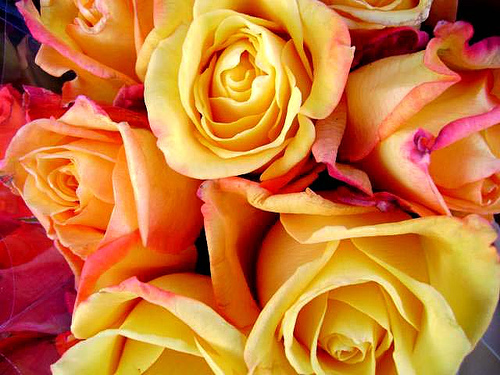

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

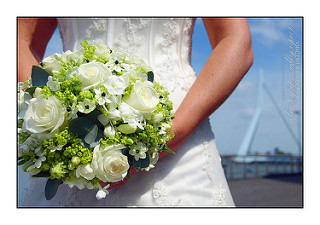

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

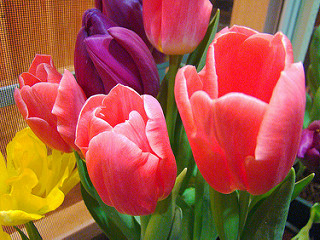

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

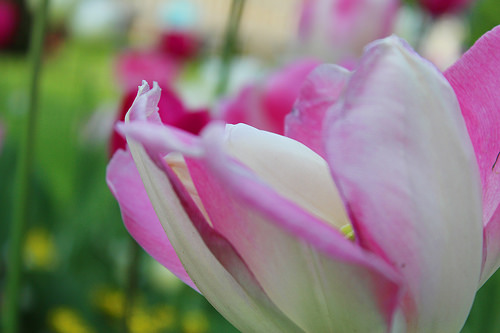

In [8]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

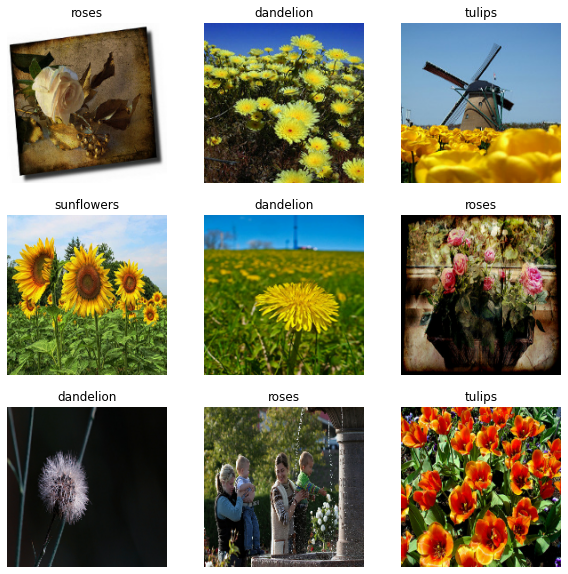

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 36s 69ms/step - loss: 1.4423 - accuracy: 0.3660 - val_loss: 1.1302 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 4s 43ms/step - loss: 0.9890 - accuracy: 0.6046 - val_loss: 0.8946 - val_accuracy: 0.6594
Epoch 3/10
92/92 [==============================] - 4s 42ms/step - loss: 0.7521 - accuracy: 0.7112 - val_loss: 0.8705 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 4s 42ms/step - loss: 0.4650 - accuracy: 0.8234 - val_loss: 0.9565 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 4s 42ms/step - loss: 0.2660 - accuracy: 0.9166 - val_loss: 1.0365 - val_accuracy: 0.6676
Epoch 6/10
92/92 [==============================] - 4s 43ms/step - loss: 0.1422 - accuracy: 0.9571 - val_loss: 1.3702 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 4s 42ms/step - loss: 0.1009 - accuracy: 0.9726 - val_loss: 1.4842 - val_accuracy: 0.6076
Epoch 8/10
9

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

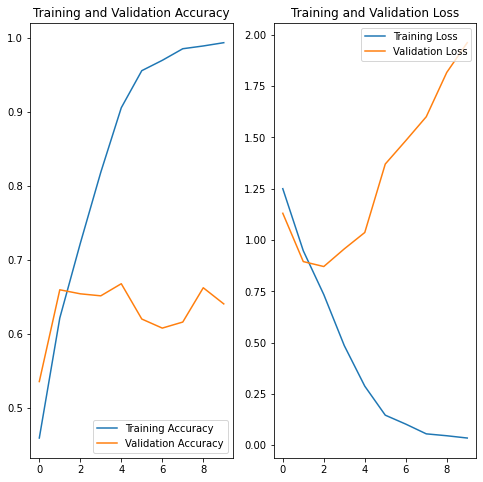

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

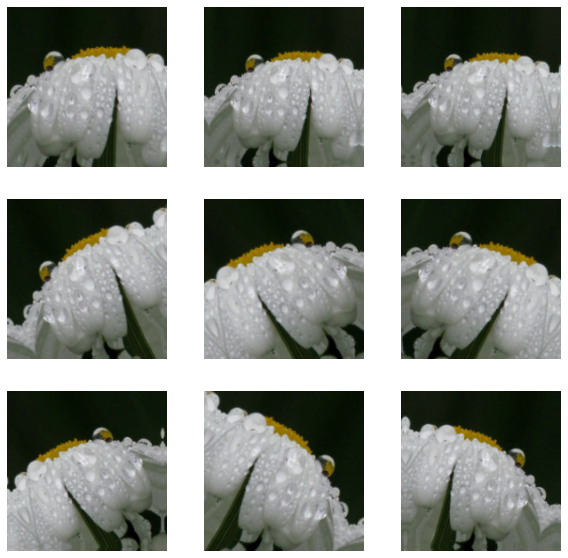

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 50ms/step - loss: 1.4559 - accuracy: 0.3651 - val_loss: 1.1423 - val_accuracy: 0.4877
Epoch 2/15
92/92 [==============================] - 4s 48ms/step - loss: 1.0732 - accuracy: 0.5614 - val_loss: 1.0432 - val_accuracy: 0.6076
Epoch 3/15
92/92 [==============================] - 4s 48ms/step - loss: 0.9119 - accuracy: 0.6499 - val_loss: 1.0005 - val_accuracy: 0.6035
Epoch 4/15
92/92 [==============================] - 4s 48ms/step - loss: 0.8536 - accuracy: 0.6647 - val_loss: 0.9486 - val_accuracy: 0.6376
Epoch 5/15
92/92 [==============================] - 4s 47ms/step - loss: 0.8083 - accuracy: 0.6896 - val_loss: 0.8539 - val_accuracy: 0.6676
Epoch 6/15
92/92 [==============================] - 4s 48ms/step - loss: 0.7310 - accuracy: 0.7061 - val_loss: 0.9392 - val_accuracy: 0.6253
Epoch 7/15
92/92 [==============================] - 4s 48ms/step - loss: 0.7699 - accuracy: 0.6949 - val_loss: 0.8190 - val_accuracy: 0.6689
Epoch 8/15
92

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

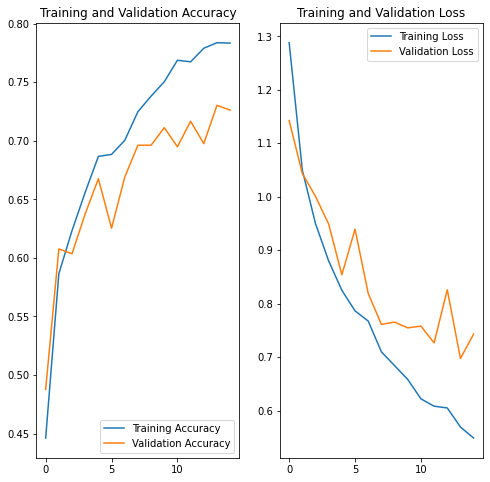

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 90.68 percent confidence.


# Exercise

This section of the notebook includes the code used to produce the results for discussion of the exercise of TP08. We did not change any of the code prior to this section, and will not interpret the following results in this notebook, as all plots have been compiled and discussed in the pdf attached in this submission.

In [45]:
from tensorflow.keras.layers import BatchNormalization

In [46]:
def model_1(batch_size=32, loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), normal=False):
  #train and validation split
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  #standardize
  normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
  image_batch, labels_batch = next(iter(normalized_ds))
  first_image = image_batch[0]

  #Create the model
  num_classes = 5
  

  if normal:
    model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),      
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(num_classes)
    ])

  else:
    model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

  #compile
  model.compile(optimizer='adam',
              loss=loss_function,
              metrics=['accuracy'])
  
  #train
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  #visualize
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [49]:
def model_2(batch_size=32, loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), drop_rate = 0.2, normal = False):
  #train and validation split
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  #standardize
  normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
  image_batch, labels_batch = next(iter(normalized_ds))
  first_image = image_batch[0]

  #Create the model
  num_classes = 5
    
  if normal:  
    model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(drop_rate),
      layers.Flatten(),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(num_classes)
    ])
  else:
    print('not normal')
    model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(drop_rate),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    

  #compile new model
  model.compile(optimizer='adam',
              loss=loss_function,
              metrics=['accuracy'])
  
  #train new model
  epochs = 50
  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

  #visualize new model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  return plt.show()

## Reference

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
92/92 [==============================] - 14s 138ms/step - loss: 1.4661 - accuracy: 0.4085 - val_loss: 1.1302 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 13s 135ms/step - loss: 0.9925 - accuracy: 0.6052 - val_loss: 0.9536 - val_accuracy: 0.6090
Epoch 3/10
92/92 [==============================] - 12s 127ms/step - loss: 0.7967 - accuracy: 0.6972 - val_loss: 0.8990 - val_accuracy: 0.6649
Epoch 4/10
92/92 [==============================] - 12s 123ms/step - loss: 0.6349 - accuracy: 0.7604 - val_loss: 0.9468 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 12s 122ms/step - loss: 0.4239 - accuracy: 0.8551 - val_loss: 1.1328 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 13s 134ms/step - loss: 0.3069 - accuracy: 0.8983 - val_loss: 1.4763 - val_accuracy: 0.59

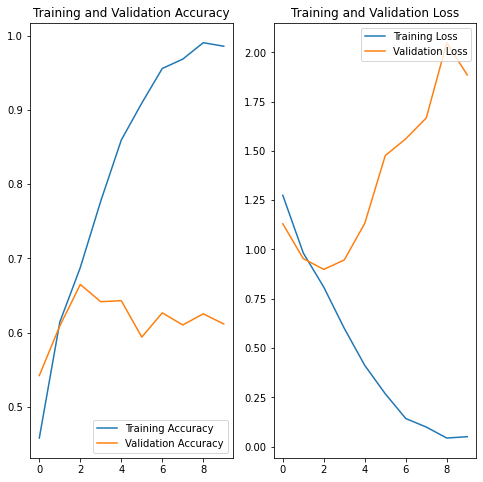

In [50]:
model_1()

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
not normal
Epoch 1/50
92/92 [==============================] - 14s 135ms/step - loss: 1.5877 - accuracy: 0.3627 - val_loss: 1.0864 - val_accuracy: 0.5572
Epoch 2/50
92/92 [==============================] - 12s 129ms/step - loss: 1.0510 - accuracy: 0.5873 - val_loss: 1.0097 - val_accuracy: 0.5831
Epoch 3/50
92/92 [==============================] - 12s 128ms/step - loss: 0.9543 - accuracy: 0.6461 - val_loss: 0.9212 - val_accuracy: 0.6553
Epoch 4/50
92/92 [==============================] - 13s 138ms/step - loss: 0.8804 - accuracy: 0.6513 - val_loss: 0.9363 - val_accuracy: 0.6471
Epoch 5/50
92/92 [==============================] - 13s 133ms/step - loss: 0.8508 - accuracy: 0.6773 - val_loss: 0.8726 - val_accuracy: 0.6689
Epoch 6/50
92/92 [==============================] - 12s 127ms/step - loss: 0.7558 - accuracy: 0.7168 - val_loss: 0.8223 - val_acc

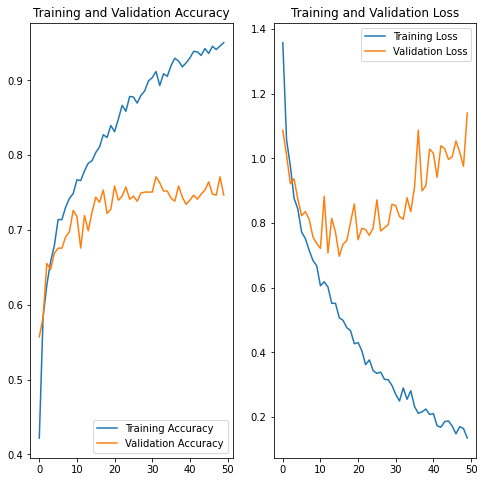

In [51]:
model_2()

## 1

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
92/92 [==============================] - 13s 127ms/step - loss: 2.1423 - accuracy: 0.2019 - val_loss: 1.3825 - val_accuracy: 0.2125
Epoch 2/10
92/92 [==============================] - 13s 135ms/step - loss: 1.3460 - accuracy: 0.1682 - val_loss: 1.3161 - val_accuracy: 0.2289
Epoch 3/10
92/92 [==============================] - 12s 129ms/step - loss: 1.1897 - accuracy: 0.1954 - val_loss: 1.1210 - val_accuracy: 0.2289
Epoch 4/10
92/92 [==============================] - 12s 125ms/step - loss: 1.0553 - accuracy: 0.2126 - val_loss: 1.1560 - val_accuracy: 0.2316
Epoch 5/10
92/92 [==============================] - 12s 125ms/step - loss: 0.9428 - accuracy: 0.1927 - val_loss: 1.1525 - val_accuracy: 0.2112
Epoch 6/10
92/92 [==============================] - 13s 135ms/step - loss: 0.8029 - accuracy: 0.1904 - val_loss: 1.1343 - val_accuracy: 0.20

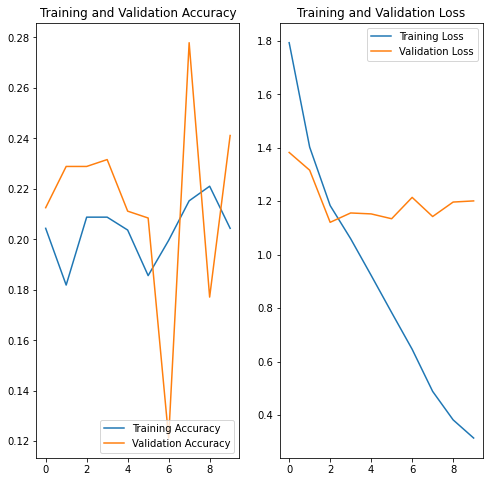

In [52]:
model_1(loss_function = tf.keras.losses.MeanSquaredError())

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
not normal
Epoch 1/50
92/92 [==============================] - 14s 133ms/step - loss: 2.3500 - accuracy: 0.1886 - val_loss: 1.4443 - val_accuracy: 0.1798
Epoch 2/50
92/92 [==============================] - 12s 127ms/step - loss: 1.3665 - accuracy: 0.1907 - val_loss: 1.2283 - val_accuracy: 0.2139
Epoch 3/50
92/92 [==============================] - 12s 128ms/step - loss: 1.2513 - accuracy: 0.1988 - val_loss: 1.2019 - val_accuracy: 0.1866
Epoch 4/50
92/92 [==============================] - 13s 136ms/step - loss: 1.2477 - accuracy: 0.1844 - val_loss: 1.1060 - val_accuracy: 0.1540
Epoch 5/50
92/92 [==============================] - 12s 130ms/step - loss: 1.1615 - accuracy: 0.1846 - val_loss: 1.1091 - val_accuracy: 0.1730
Epoch 6/50
92/92 [==============================] - 12s 128ms/step - loss: 1.0893 - accuracy: 0.2200 - val_loss: 1.2504 - val_acc

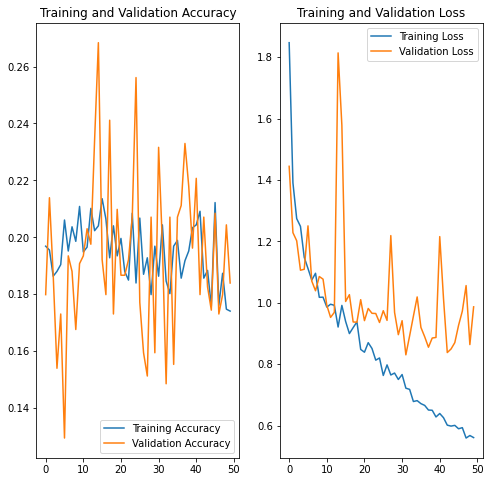

In [53]:
model_2(loss_function = tf.keras.losses.MeanSquaredError())

## 2

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
not normal
Epoch 1/50
92/92 [==============================] - 13s 131ms/step - loss: 1.5334 - accuracy: 0.3266 - val_loss: 1.1238 - val_accuracy: 0.5477
Epoch 2/50
92/92 [==============================] - 13s 140ms/step - loss: 1.0784 - accuracy: 0.5636 - val_loss: 1.0297 - val_accuracy: 0.5654
Epoch 3/50
92/92 [==============================] - 12s 128ms/step - loss: 0.9603 - accuracy: 0.6328 - val_loss: 0.9395 - val_accuracy: 0.6308
Epoch 4/50
92/92 [==============================] - 12s 127ms/step - loss: 0.8924 - accuracy: 0.6552 - val_loss: 0.9792 - val_accuracy: 0.6063
Epoch 5/50
92/92 [==============================] - 12s 127ms/step - loss: 0.8588 - accuracy: 0.6638 - val_loss: 0.8497 - val_accuracy: 0.6580
Epoch 6/50
92/92 [==============================] - 13s 136ms/step - loss: 0.7792 - accuracy: 0.7050 - val_loss: 0.9118 - val_acc

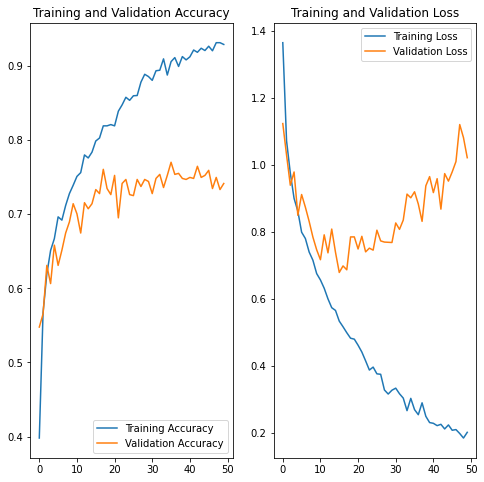

In [54]:
model_2(drop_rate=0.4)

## 3

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
367/367 [==============================] - 15s 38ms/step - loss: 1.5490 - accuracy: 0.3629 - val_loss: 1.0537 - val_accuracy: 0.6090
Epoch 2/10
367/367 [==============================] - 14s 38ms/step - loss: 0.9744 - accuracy: 0.6022 - val_loss: 0.9108 - val_accuracy: 0.6458
Epoch 3/10
367/367 [==============================] - 14s 39ms/step - loss: 0.7744 - accuracy: 0.7055 - val_loss: 0.9817 - val_accuracy: 0.6131
Epoch 4/10
367/367 [==============================] - 16s 42ms/step - loss: 0.5891 - accuracy: 0.7742 - val_loss: 1.1222 - val_accuracy: 0.6335
Epoch 5/10
367/367 [==============================] - 15s 42ms/step - loss: 0.3601 - accuracy: 0.8685 - val_loss: 1.5133 - val_accuracy: 0.6335
Epoch 6/10
367/367 [==============================] - 15s 42ms/step - loss: 0.2473 - accuracy: 0.9185 - val_loss: 1.7910 - val_accuracy

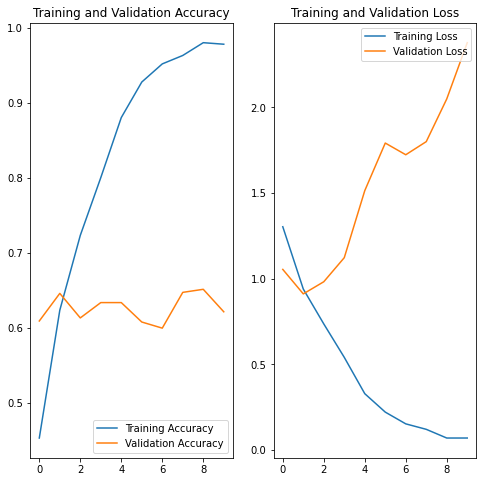

In [55]:
model_1(batch_size=8)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
not normal
Epoch 1/50
367/367 [==============================] - 18s 45ms/step - loss: 1.5476 - accuracy: 0.3201 - val_loss: 1.1493 - val_accuracy: 0.5409
Epoch 2/50
367/367 [==============================] - 16s 44ms/step - loss: 1.0519 - accuracy: 0.5773 - val_loss: 0.9798 - val_accuracy: 0.6253
Epoch 3/50
367/367 [==============================] - 16s 44ms/step - loss: 0.9315 - accuracy: 0.6377 - val_loss: 0.9528 - val_accuracy: 0.6226
Epoch 4/50
367/367 [==============================] - 16s 44ms/step - loss: 0.8521 - accuracy: 0.6690 - val_loss: 0.8285 - val_accuracy: 0.6580
Epoch 5/50
367/367 [==============================] - 17s 45ms/step - loss: 0.8019 - accuracy: 0.7002 - val_loss: 0.8055 - val_accuracy: 0.6744
Epoch 6/50
367/367 [==============================] - 17s 46ms/step - loss: 0.7341 - accuracy: 0.7266 - val_loss: 0.7584 - v

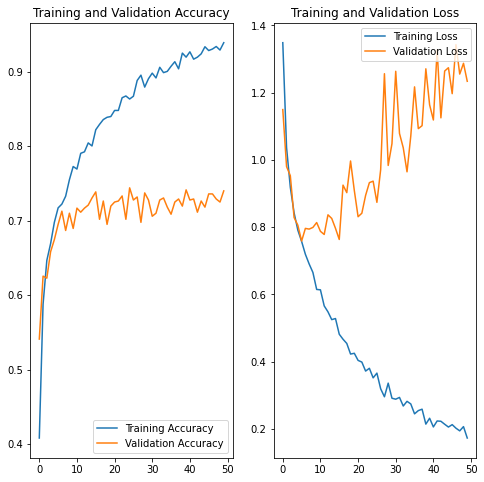

In [56]:
model_2(batch_size=8)

## 4

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
92/92 [==============================] - 15s 143ms/step - loss: 1.5976 - accuracy: 0.4805 - val_loss: 2.3209 - val_accuracy: 0.2398
Epoch 2/10
92/92 [==============================] - 13s 133ms/step - loss: 0.7371 - accuracy: 0.7214 - val_loss: 2.1137 - val_accuracy: 0.2398
Epoch 3/10
92/92 [==============================] - 12s 129ms/step - loss: 0.4808 - accuracy: 0.8364 - val_loss: 1.6038 - val_accuracy: 0.3161
Epoch 4/10
92/92 [==============================] - 13s 133ms/step - loss: 0.2700 - accuracy: 0.9167 - val_loss: 1.4404 - val_accuracy: 0.4728
Epoch 5/10
92/92 [==============================] - 13s 133ms/step - loss: 0.1757 - accuracy: 0.9476 - val_loss: 1.9622 - val_accuracy: 0.4305
Epoch 6/10
92/92 [==============================] - 13s 131ms/step - loss: 0.0913 - accuracy: 0.9792 - val_loss: 1.1267 - val_accuracy: 0.62

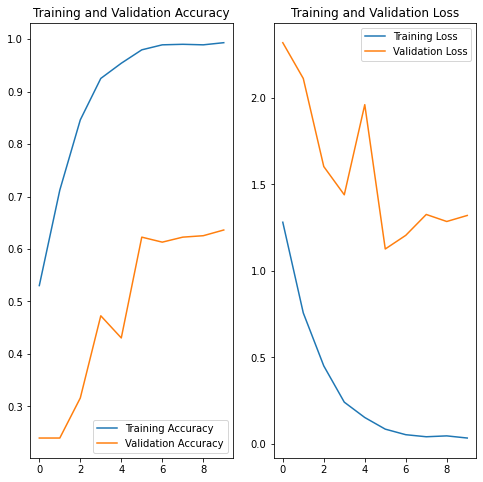

In [57]:
model_1(normal=True)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/50
92/92 [==============================] - 14s 134ms/step - loss: 1.6171 - accuracy: 0.4876 - val_loss: 1.8171 - val_accuracy: 0.2670
Epoch 2/50
92/92 [==============================] - 13s 139ms/step - loss: 0.9638 - accuracy: 0.6247 - val_loss: 2.0523 - val_accuracy: 0.2779
Epoch 3/50
92/92 [==============================] - 13s 133ms/step - loss: 0.8760 - accuracy: 0.6533 - val_loss: 1.5766 - val_accuracy: 0.3256
Epoch 4/50
92/92 [==============================] - 13s 132ms/step - loss: 0.8299 - accuracy: 0.6735 - val_loss: 1.3788 - val_accuracy: 0.4292
Epoch 5/50
92/92 [==============================] - 13s 132ms/step - loss: 0.7600 - accuracy: 0.6974 - val_loss: 1.2369 - val_accuracy: 0.5082
Epoch 6/50
92/92 [==============================] - 14s 143ms/step - loss: 0.7641 - accuracy: 0.7136 - val_loss: 0.8484 - val_accuracy: 0.64

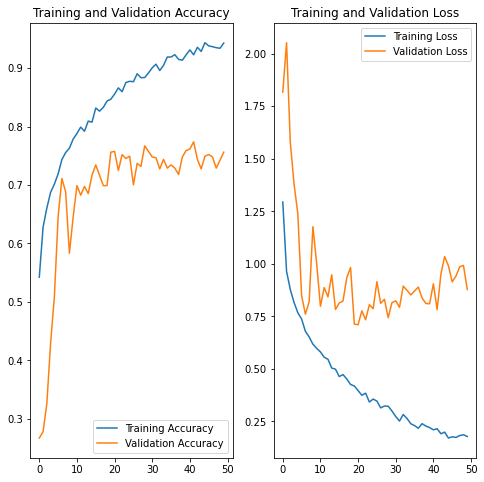

In [58]:
model_2(normal=True)